In [ ]:
import matplotlib.pyplot as plt
# https://stackoverflow.com/questions/45466947/include-output-from-matplotlib-notebook-backend-as-svg-in-ipynb
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import tempfile
import subprocess
import os
import json
from types import SimpleNamespace
from statistics import harmonic_mean

CWD = os.getcwd()
NS_PER_US = 1e3
print(f'Running in {CWD}.. this should be the project root folder!')

In [2]:
def measure(samplerMod, sampleCmd, constNm, dataFile):
  with tempfile.NamedTemporaryFile(mode='w', suffix='.lean', encoding='utf-8') as f:
    f.write(f'''
      import bench.samplers.{samplerMod}
      import bench.measure
      set_option maxHeartbeats 0
      {sampleCmd}
      #measure {constNm} "{dataFile}" 0
    ''')
    f.flush()
    subprocess.run(["lake", "lean", f.name], cwd=CWD)

In [71]:
N = 39
for i in range(N):
  # Measure the timing for each definition in a separate Lean process
  # to eliminate any potential cross-definition caching.
  measure('pair', f'#sample_pairs {N}', f'benchDef_pair_{i}', 'bench/2025_09_05_times_pair_cache.ndjson')

In [3]:
data = {}
with open('bench/2025_09_05_times_pair_cache.ndjson', 'r') as f:
  for line in f:
    obj = json.loads(line, object_hook=lambda d: SimpleNamespace(**d))
    # Prefers latest data when seeing multiple entries for the same definition
    data[obj.name] = obj

In [4]:
xs = [ ob.sz_val for ob in data.values() ]
ys = [ ob.t_kernel for ob in data.values() ]
rys = [ ob.t_rkernel_shared for ob in data.values() ]
(xs, ys, rs) = zip(*sorted(zip(xs, ys, rys)))

print(f'Kernel (deep) / kernel: {harmonic_mean([ry/y for (ry, y) in zip(rys, ys)])}')

Kernel (deep) / kernel: 1630.145734821825


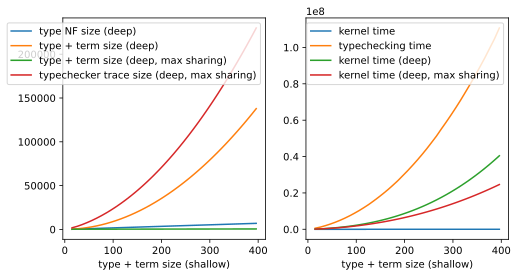

In [5]:
xs = [ ob.sz_val + ob.sz_tp for ob in data.values() ]
ys = [ ob.sz_deep_val + ob.sz_deep_tp for ob in data.values() ]
yss = [ ob.sz_deep_val_shared + ob.sz_deep_tp_shared for ob in data.values() ]
ts = [ ob.t_kernel for ob in data.values() ]
rs = [ ob.t_translate for ob in data.values() ]
cs = [ ob.t_typecheck for ob in data.values() ]
ns = [ ob.sz_deep_nfTp for ob in data.values() ]
ws = [ ob.sz_deep_wf_val for ob in data.values() ]
sws = [ ob.sz_deep_wf_val_shared for ob in data.values() ]
ks = [ ob.t_rkernel for ob in data.values() ]
kss = [ ob.t_rkernel_shared for ob in data.values() ]
vs = [ ob.sz_deep_val + ob.sz_deep_tp + ob.sz_deep_nfTp + ob.sz_deep_wf_nfTp + ob.sz_deep_wf_val for ob in data.values() ]
(xs, ys, yss, ts, rs, cs, ns, ws, sws, ks, kss, vs) = zip(*sorted(zip(xs, ys, yss, ts, rs, cs, ns, ws, sws, ks, kss, vs)))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 4)

ax1.set_xlabel("type + term size (shallow)")
# constant in the id benchmark
ax1.plot(xs, ns, label="type NF size (deep)")
ax1.plot(xs, ys, label="type + term size (deep)")
ax1.plot(xs, yss, label="type + term size (deep, max sharing)")
# ax1.plot(xs, ws, label="typechecker trace size (deep)")
ax1.plot(xs, sws, label="typechecker trace size (deep, max sharing)")
# ax1.plot(xs, vs, label="value size (deep)")
ax1.legend()

ax2.set_xlabel("type + term size (shallow)")
ax2.plot(xs, ts, label="kernel time")
# ax2.plot(xs, rs, label="translation time")
ax2.plot(xs, cs, label="typechecking time")
ax2.plot(xs, ks, label="kernel time (deep)")
ax2.plot(xs, kss, label="kernel time (deep, max sharing)")
ax2.legend()
